<a href="https://colab.research.google.com/github/inhovation97/Get-an-education-Computer-Vision/blob/main/GAN/Style_transfer_20210802.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [ ]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()

# 구글 드라이브 mount 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/서울 ICT이노베이션스퀘어

/content/gdrive/MyDrive/서울 ICT이노베이션스퀘어


![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```

In [ ]:
from keras.preprocessing.image import load_img, img_to_array, save_img

# 변환하려는 이미지 경로
target_image_path = './joo.png'
# 스타일 이미지 경로
style_reference_image_path = './ani.png'

# 생성된 사진의 차원
width, height = load_img(target_image_path).size
print (width, height)
img_height = 400
img_width = int(width * img_height / height)
print (width, height)


278 278
278 278


In [ ]:
print (img_width)

400


In [ ]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width)) # 이미지 읽기
    img = img_to_array(img) # 이미지 array
    # H,W,C
    img = np.expand_dims(img, axis=0)
    # N,H,W,C
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x): # 다시 눈으로 볼 수 있는 값으로 renormalize
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path)) # 타겟 이미지
style_reference_image = K.constant(preprocess_image(style_reference_image_path)) # 스타일 이미지

# 생성된 이미지를 담을 플레이스홀더
combination_image = K.placeholder((1, img_height, img_width, 3))

# 세 개의 이미지를 하나의 배치로 합칩니다
input_tensor = K.concatenate([target_image,     # 세장의 이미지가 함께 들어가도록 배치로 만듦
                              style_reference_image,
                              combination_image], axis=0)

# 세 이미지의 배치를 입력으로 받는 VGG 네트워크를 만듭니다.
# 이 모델은 사전 훈련된 ImageNet 가중치를 로드합니다
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False) # conv layer만 가져오기
print('모델 로드 완료.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

80142336/80134624 [==============================] - 1s 0us/step
모델 로드 완료.


In [ ]:
def content_loss(base, combination): # 컨텐츠 loss
    return K.sum(K.square(combination - base))

In [ ]:
def gram_matrix(x): # style loss
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [ ]:
def total_variation_loss(x): 
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :]) # x축으로 이동하면서 옆 픽셀 간의 차이
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])# y축으로 이동하면서 상하 픽셀 간의 차이
    return K.sum(K.pow(a + b, 1.25))

In [ ]:
# 층 이름과 활성화 텐서를 매핑한 딕셔너리
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 콘텐츠 손실에 사용할 층
content_layer = 'block5_conv2'
# 스타일 손실에 사용할 층
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# 손실 항목의 가중치 평균에 사용할 가중치      -> 이 loss 가중치 값들은 내가 좀 더 치중하고 싶은 것에 더 가감하면 됨
total_variation_weight = 1e-4 # 10의 -4 제곱
style_weight = 3.025 # dfualt 0.025
content_weight = 1

# 모든 손실 요소를 더해 하나의 스칼라 변수로 손실을 정의합니다
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, # 컨텐츠 loss 먼저 구함
                                      combination_features)

for layer_name in style_layers: # style conv 층을 돌면서 style loss 구함
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] # 3개를 묶은 인풋 텐서에서 0,1,2 순대로 콘텐츠, 스타일, 콤비네이션
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl # 평균적으로 들어가게 보정하여 sl을 곱해줌
    
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [ ]:
# 손실에 대한 생성된 이미지의 그래디언트를 구합니다
grads = K.gradients(loss, combination_image)[0] # 합성된 이미지와 loss를 편미분해 gradient를 구함

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads]) 


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator() # 인스턴스 생성

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [ ]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 50

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img) # 볼 수 있는 이미지 스케일로 변환
    fname = result_prefix + '_at_iteration_%d.png' % i 
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 5370230000.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 22s
반복 횟수: 1
현재 손실 값: 2724845000.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 12s
반복 횟수: 2
현재 손실 값: 1895770000.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 12s
반복 횟수: 3
현재 손실 값: 1511378800.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 12s
반복 횟수: 4
현재 손실 값: 1293814500.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 12s
반복 횟수: 5
현재 손실 값: 1152622300.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 12s
반복 횟수: 6
현재 손실 값: 1052363200.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 12s
반복 횟수: 7
현재 손실 값: 979466940.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 12s
반복 횟수: 8
현재 손실 값: 923998400.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 12s
반복 횟수: 9
현재 손실 값: 875484800.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 12s
반복 횟수: 10
현재 손실 값: 835180200.0
저장

In [ ]:
from matplotlib import pyplot as plt

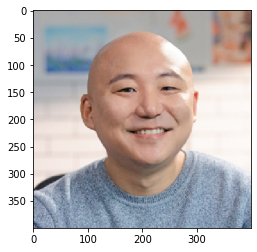

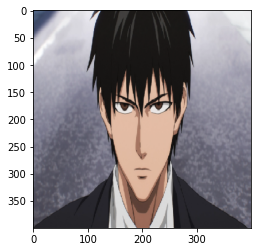

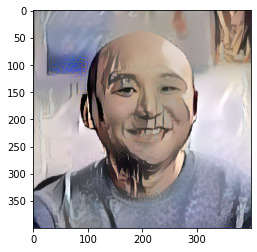

In [ ]:
# 콘텐츠 이미지
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# 스타일 이미지
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# 생성된 이미지
plt.imshow(img)
plt.show()